In [4]:
# ! pip install seaborn

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from importlib import reload

import simulate
from simulate import simulate_data, bayes_boundary, parabola, circle, boundary_1
import plotting
from plotting import plot_two_variables, plot_roc_curve, plot_clf_decision_boundary, plot_strategy_curve, plot_classifier_profit

In [83]:
from xgboost import XGBClassifier
from probatus.metric_uncertainty import VolatilityEstimation
from sklearn.model_selection import train_test_split

In [84]:
# data = simulate_data(population_size=N_population, N_cont_variables=5, N_exponential_variables=5, N_normal_variables=5)

In [85]:
import seaborn as sns

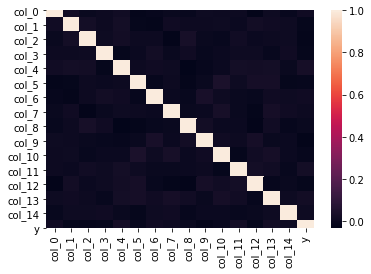

In [86]:
sns.heatmap(data.corr())

### Define function for boundary

In [339]:
xgb_mod = XGBClassifier(
    n_estimators=50,
    max_depth=2
)

N_population = 5500
data = simulate_data(population_size=N_population, N_cont_variables=5, N_exponential_variables=5, N_normal_variables=5)

def custom_func(x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,bias,we):
    return (
        10*x1*x1 + 
        5*x2*x2*x2 - 
        5*x3 +
        2.5 * (x4-10) +
        3 * x5*x5*np.log(x5) +
        0.5 * x6 -
        2* np.log(x7) +
        0.3 *x8*x8 +
        0.1 * x9 *x9 *x9 +
        0.4 *np.exp(x10) + 
        bias

    )


In [340]:
probs,targets,coordinates = bayes_boundary(
    boundary_func=custom_func,
    print_median=True, 
    x1 = data['col_3'], 
    x2 = data['col_4'],
    x3 = data['col_6'],
    x4 = data['col_7'],
    x5 = data['col_12'],
    x6 = data['col_1'],
    x7 = data['col_2'],
    x8 = data['col_5'],
    x9 = data['col_10'],
    x10 = data['col_11'],
    bias=22.5,
    max_accuracy=0.98,
    threshold=0.9)

targets.value_counts()

4.056735977766085


/Users/we56sc/Developer/.miniconda3/envs/py36/lib/python3.6/site-packages/pandas/core/series.py:853: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


1    4414
0    1086
dtype: int64

In [341]:
coordinates

{'x1': 0       0.794093
 1       0.138069
 2       0.423429
 3       0.924668
 4       0.729517
           ...   
 5495    0.975209
 5496    0.800398
 5497    0.228658
 5498    0.850908
 5499    0.323385
 Name: col_3, Length: 5500, dtype: float64, 'x2': 0       0.459724
 1       0.867105
 2       0.318287
 3       0.437124
 4       0.950792
           ...   
 5495    0.767497
 5496    0.261766
 5497    0.307342
 5498    0.136423
 5499    0.140645
 Name: col_4, Length: 5500, dtype: float64, 'x3': 0       2.143956
 1       2.152842
 2       1.577674
 3       1.228129
 4       2.361440
           ...   
 5495    0.743415
 5496    1.469577
 5497    3.174107
 5498    0.992876
 5499    0.140636
 Name: col_6, Length: 5500, dtype: float64, 'x4': 0       1.099267
 1       0.736017
 2       0.022213
 3       1.704971
 4       0.332101
           ...   
 5495    2.186443
 5496    2.023356
 5497    2.454121
 5498    0.324864
 5499    1.298089
 Name: col_7, Length: 5500, dtype: float64, 'x5': 0    

In [305]:
data['y_10'] = targets

In [306]:
data.columns

Index(['col_0', 'col_1', 'col_2', 'col_3', 'col_4', 'col_5', 'col_6', 'col_7',
       'col_8', 'col_9', 'col_10', 'col_11', 'col_12', 'col_13', 'col_14',
       'y_3', 'y_4', 'y_5', 'y_6', 'y_7', 'y_8', 'y_9', 'y_10'],
      dtype='object')

In [158]:
##### assign it to the dataset
data['y']=targets

# #show the first five values
# data.head(5)

X = data[[col for col in data.columns if 'col' in col]]
y = targets

data.y.value_counts()

1    4955
0     545
Name: y, dtype: int64

In [145]:
# defining the metrics we are interested in
evaluators =  {'AUC' : [roc_auc_score,'proba']}

# declaring the evaluation class
checker = VolatilityEstimation(xgb_mod, 
                               X,#.drop('col_4',axis=1), 
                               y, evaluators, 'boot_seed', n_jobs=-1)

# running 1000 random samples with 40% of data assigned to test partition
checker.estimate(0.25,500)

In [317]:
def run_checker(data, ix = 3):
    print(ix)
    X = data[[col for col in data.columns if 'col' in col]]
    y = data['y_{}'.format(ix)]
    
    checker = VolatilityEstimation(xgb_mod, 
                               X,#.drop('col_4',axis=1), 
                               y, evaluators, 'boot_seed', n_jobs=-1)
    checker.estimate(0.25,300)
    
    return checker
    

In [318]:
# data.to_csv('simulated_data.csv')

In [319]:
checkers = [
    run_checker(data,ix=ix)
    for ix in range(3,11)
]

3
4
5
6
7
8
9
10


In [321]:
check = checkers[0]

In [330]:
mean_test = [
    check.metrics_list['AUC'][:,1].mean() for check in checkers
]

std_test = [
    check.metrics_list['AUC'][:,1].std() for check in checkers
]

mean_train = [
    check.metrics_list['AUC'][:,0].mean() for check in checkers
]

std_train = [
    check.metrics_list['AUC'][:,0].std() for check in checkers
]

mean_oft = [
    check.metrics_list['AUC'][:,2].mean() for check in checkers
]

std_oft = [
    check.metrics_list['AUC'][:,2].std() for check in checkers
]

In [331]:
x_axis = list(range(3,11))
x_axis

[3, 4, 5, 6, 7, 8, 9, 10]

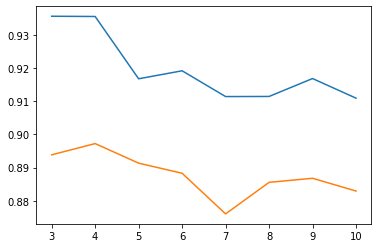

In [336]:
plt.plot(x_axis,mean_train)
plt.plot(x_axis,mean_test)

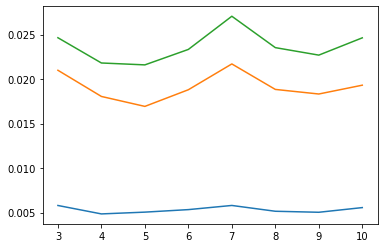

In [338]:
plt.plot(x_axis,std_train)
plt.plot(x_axis,std_test)
plt.plot(x_axis,std_oft)

In [ ]:
plt.plot(x_axis,std_train)
plt.plot(x_axis,std_test)

In [111]:
xgb_mod = XGBClassifier(
    n_estimators=50,
    max_depth=2
)

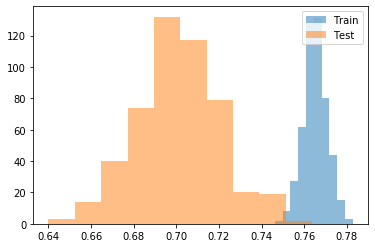

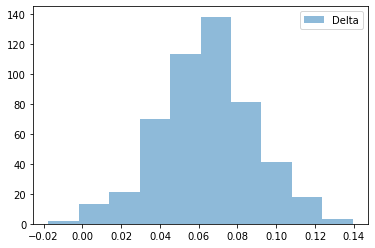

In [136]:
checker.plot('AUC')

In [137]:
checker.reporting('AUC')

Mean of metric on train is 0.77
Mean of metric on test is 0.7
Mean of delta is 0.06
Standard Deviation of metric on train is 0.00558
Standard Deviation of metric on test is 0.01974
Standard Deviation of delta is 0.02451


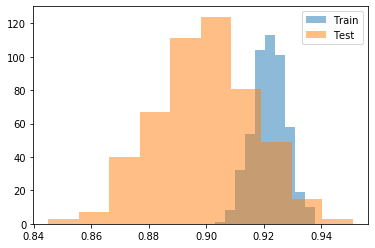

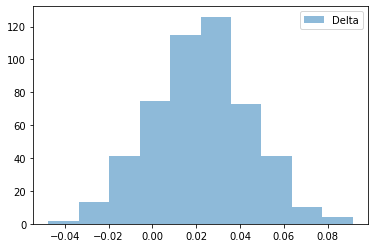

In [140]:
checker.plot('AUC')

In [141]:
checker.reporting('AUC')

Mean of metric on train is 0.92
Mean of metric on test is 0.9
Mean of delta is 0.02
Standard Deviation of metric on train is 0.0058
Standard Deviation of metric on test is 0.01731
Standard Deviation of delta is 0.02239


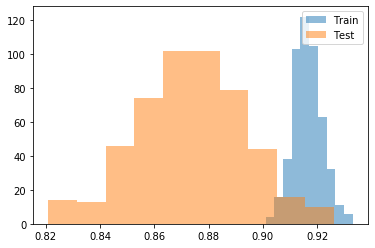

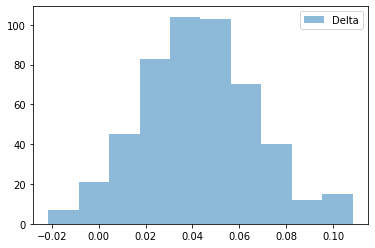

In [146]:
checker.plot('AUC')

In [147]:
checker.reporting('AUC')

Mean of metric on train is 0.92
Mean of metric on test is 0.87
Mean of delta is 0.04
Standard Deviation of metric on train is 0.00529
Standard Deviation of metric on test is 0.01993
Standard Deviation of delta is 0.02406


In [133]:
print(checker.metrics_list['AUC'][:,0].mean())
print(checker.metrics_list['AUC'][:,1].mean())
print(checker.metrics_list['AUC'][:,2].mean())

0.7595709824854304
0.6839279644245769
0.0756430180608536
